In [9]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import init_lattice as lat
import MH_algorithm as MH
import Wolff_algorithm as W
import time
import autocorrelation_functions as acf
importlib.reload(MH)
importlib.reload(W)
importlib.reload(lat)
importlib.reload(acf)

<module 'autocorrelation_functions' from 'c:\\Users\\jackb\\github-classroom\\Part-II-Computational-Physics\\cluster-algorithms-for-monte-carlo-jbd29\\autocorrelation_functions.py'>

# Monte Carlo and cluster algorithms for the 2D Ising Model

## Abstract - TO FINISH

The Ising model for ferromagnets is a common and well researched topic in statistical mechanics both computationally and analytically. Many different algorithms with differing complexities and strengths have been devised to simulate the behaviour of this model. In this project, the behaviour and complexity of the Metropolis-Hastings and Wolff Cluster algorithms applied to this context was investigated. This report focuses particularly on the simulated behaviour at and around the critical temperature $T_c$ of the continuous phase transition, where these algorithms differ. The efficiency of the algorithms is also calculated by means of the dynamic critical exponent.

The Wolff algorithm and Metropolis-Hastings algorithm were studied to assess their efficiency and performance in simulating the 2 dimensional Ising model. An implementation of each was written in python and their behaviour around the continuous phase transtion investigated. Both simulated the large and small temperature limits successfully. The critical temperatures measured were $2.63 \pm 0.08$ and $2.30 \pm 0.08$ for the Wolff and Metropolis-Hasstings algorithms respectively. The Wolff measurement is consistent with previously published values. However, the measurement from the implementation of the Metropolis-Hastings are not consistent with previously published values. The Wolff algorithm displayed shorter autocorrelation times than the Metropolis-Hastings algorithm, showing its lesser vulnerability to the phenomenon of critical slowing down. Attempts to measure the dynamic exponent for both algorithms were far from literature values and neither regression fit was significant. Dependence of time to execute a single iteration on coupling strength and lattice size were also investigated. Wolff had longer single iteration exectution times for all measured conditions, and Metropolis-Hastings execution time displayed no dependence on either condition.

## Introduction

In this report, the Metropolis-Hastings and Wolff algorithms are implmemented and their performance and results are investigated. Of particular focus is the issue of *critical slowing down*. This is a phenomena that occurs near to the continuous phase transition, where both algorithm take significantly larger numbers of iterations to produce independent samples of the measurement at hand. The performance of these algorithms, in terms of dynamic exponent and agreement to the analytic Onsager solution is explored below.

## Theory

### 1 - Background Theory

The Ising model considers individual spins, $\sigma_i$, arranged in space. For the purposes of this report, spins will be placed upon an $L\times L$ square lattice. This model assumes that these individual spins may be directed only up or down, i.e. $\sigma_i = \pm 1$, and that each spin interacts with only its nearest neighbours on the lattice. The total energy of the system is then:

$ E = -J \sum_i \sum_j \sigma_i \sigma_j - \mu H \sum_i \sigma_i $ (1) [1]

where for each spin $i$ its nearest neighbours, $j$, are summed over. Additionally, $J$ is the ferromagnetic coupling, $\mu$ is the spin's magnetic moment and $H$ is the external magnetic field. In this report, we will be considering the zero external magnetic field regime.

Typical state observables of interest for this system are the absolute magnetism per spin $\vert M \vert$, And the internal energy (equation (1)).

$ \vert M \vert = \vert \frac{1}{N} \sum_{i = 1}^N \sigma_i \vert $ (2)

For ensemble systems, The expectation value of a state observable $f$ is found using:

$ \mathbb{E}(f) = \sum_{\sigma states} f(\sigma)p(\sigma)$ (3)

with $p(\sigma)$ being the probabilty density for a specific $\sigma$ state. From statistical mechanics, recall that for such a system,

$ p(\sigma) = \frac{e^{- \beta E}}{Z} $ (4)

Where $Z = \sum_{states} e^{-\beta E_{state}}$ is the partition function, and $\beta = \frac{1}{k_b T}$. For convenience, $\beta = 1$ throughout this report. From these measurements, two *derived observables* of the system which are of interest can also be found. Firstly, the magnetic susceptibility, $\chi$:

$ \chi \propto \beta(\langle M^2 \rangle - \langle M \rangle ^2) = \beta Var(M)$ (4)

and the heat capacity, $C$:

$ C \propto \beta^2 (\langle E^2 \rangle - \langle E \rangle ^2) = \beta ^2 Var(E)$ (5)

These are known as derived variables as they require several measurements of $M$ or $E$ respectively to be found.

For a general Ising system, whilst $Z$ is constant, it is not feasibly calculable. To illustrate this consider an $N \times N$ lattice of spins. To compute $Z$, we must (at worst) sum up $2^{N \times N}$ terms for each possible lattice configuration; this sum quickly becomes astronomic in scale. Hence, we must approach this problem in a manner that depends only on relative likelihood, not absolute probability as this allows $Z$ to be disregarded.

In some limiting cases, the behaviour of this system is analytically solvable, for example the Onsager solution for 2 dimensions with no external field, this is typically tedious, or infeasibly complex. This is the motivation for studying this system with computational methods. However, comparison of computational methods to the establsihed Onsager solution is a convenient sanity check for the accuracy and precision.

### The Onsager Solution

In 1944, Onsager found an analytical expression for the free energy and magnetism of the 2D square lattice Ising model in the limit of $L \rightarrow \infty$ and with no eternal magnetic field. Below is the solution for the magnetisation In the case relevant to this report, with isotropic couping:

$\mathbb{E}(M) = (1 - (sinh(2 \beta J)^{-4}))^{\frac{1}{8}} $ for $ T \le T_c $

$\mathbb{E}(M) = 0$ for $ T > T_c $ (6)

The non zero solution clearly is only defined if $sinh(2 \beta J) \ge 1$. This defines our *critical temperature*, $T_c = \frac{2 J}{ln(1 + \sqrt{2})} \approx 2.27J$ . There is a continuous phase transition at $T = T_c$ at which the spins rapidly transition from ordered to disordered, leading to the order parameter, $\vert M \vert$, changing abruptly. Figure 1 plots this solution.

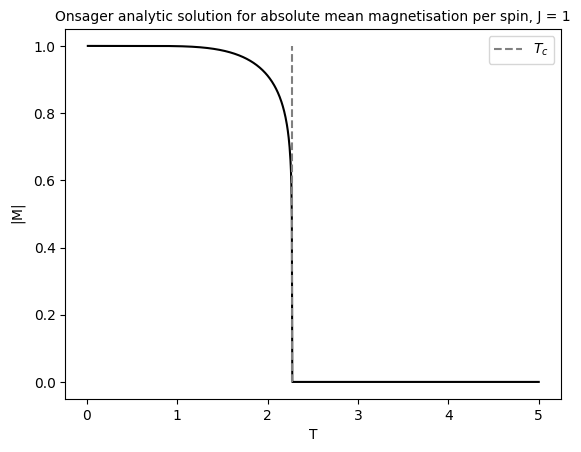

In [3]:
# Plot Onsager solution, J = 1:
J = 1
Ts_analytic = np.linspace(0.01,5,1000)
T_c = 2*J/np.log(1 + np.sqrt(2)) # Critical temperature

# Construct absolute magnetism:
M_analytic = []

for T in Ts_analytic:
    if T < T_c:
        M_analytic.append(np.power(1 - np.power(np.sinh(2*J/T),-4),1/8))
    else:
        M_analytic.append(0)

# Plot:
plt.plot(Ts_analytic, M_analytic, color = 'black')
plt.plot(np.full((5,1),T_c), np.linspace(0,1,5), linestyle = '--', color = 'gray', label = r'$T_c$')
plt.xlabel('T')
plt.ylabel(r'$\vert$M$\vert$')
plt.title('Onsager analytic solution for absolute mean magnetisation per spin, J = ' + str(J), fontsize = 10)
plt.legend()
plt.show()

*Fig. 1 - mean magnetisation per spin against temperature for the Onsager solution.*

As mentioned, the Onsager solution applies only to an infinite lattice. This cannot be implemented into a computational model, therefore finite lattices with periodic boundaries are to be considered in this report. It is expected that for finite lattices that there will be a 'smoothing out' of the Onsager solution. An analytic example of this must be calculated by exhaustion to find all possible states and the associated Boltzmann factor and partition function. 

The exhaustion method to obtain the spontaneous magnetisation per spin was performed for a $2 \times 2$ lattice without perioidic boundary conditions. Figure 2 illustrates all possible permutations of this lattice
Consider all the permutations of the $2 \times 2$ lattice, along with the associated $E$ and $\vert M \vert$:


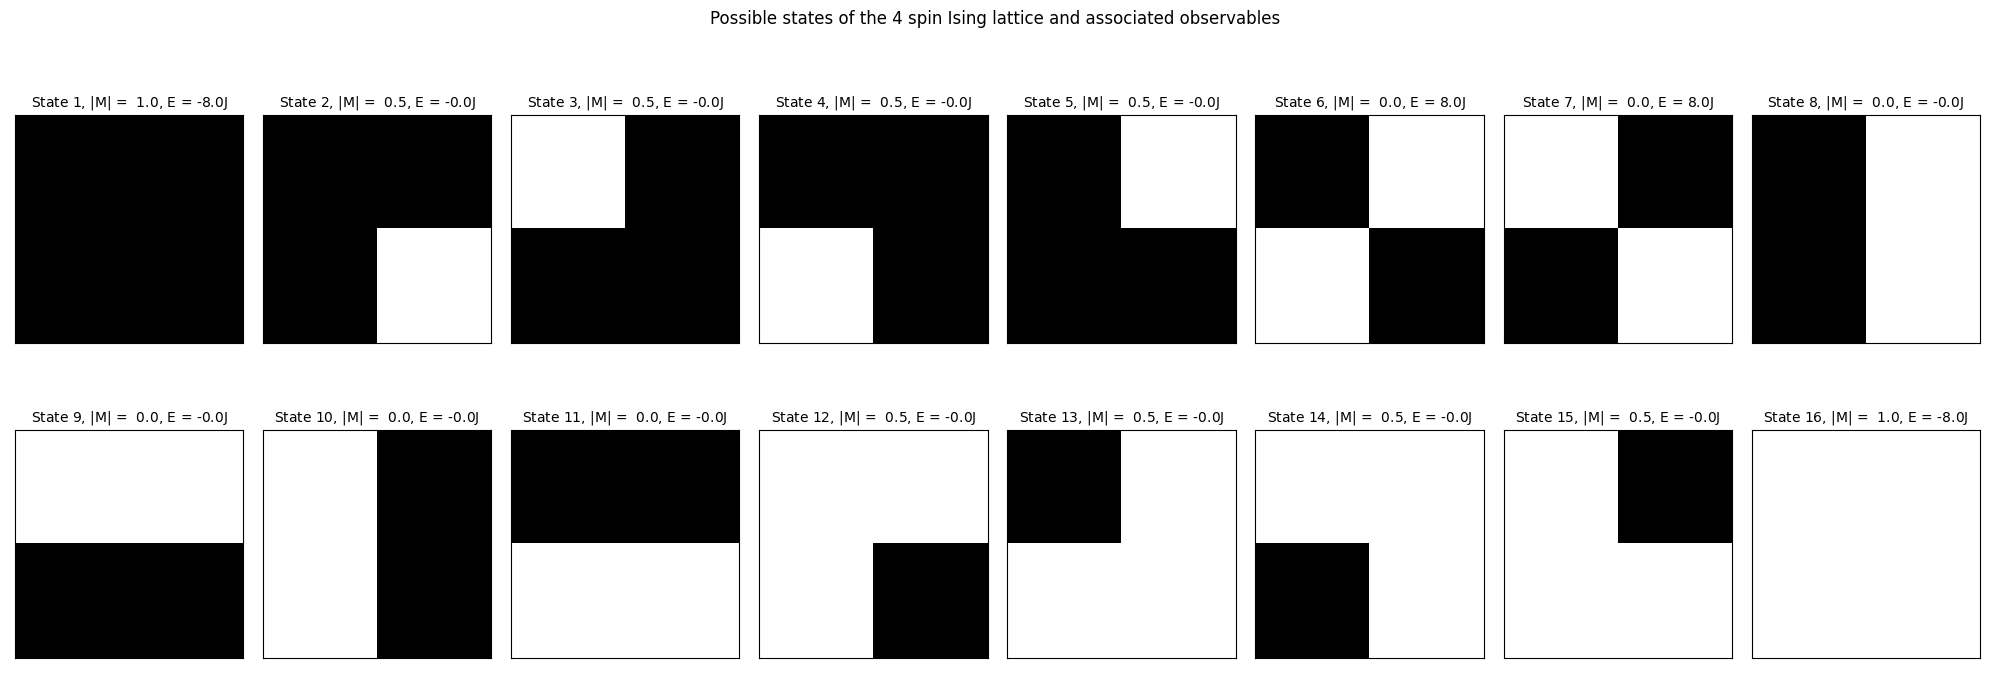

In [5]:
import itertools

#write a lattice for each number of -1 entries:
lattices = [[[1.,1.], [1.,1.]], [[-1.,1.], [1.,1.]], [[-1.,-1.], [1.,1.]], [[-1.,-1.], [-1.,1.]], [[-1.,-1.], [-1.,-1.]]]

# Write a function to split into individual elements to use itertools on, and then generate all permutations
def permutations(lattice):
    #split into  list of elements
    temp = []
    for i in lattice:
        for j in i:
            temp.append(j)
    
    # Use itertools to generate permutations and then use set to remove duplicates
    permutations = list(set(itertools.permutations(temp,np.size(lattice))))
    #print(len(permutations))
    # Reshape into lattices
    for i in range(len(permutations)):
        permutations[i] = np.reshape(np.array(permutations[i]), (len(lattice),len(lattice)))
    
    return permutations

fig, ax = plt.subplots(2,8, figsize = (20,7.5))

i = 0
for lattice in lattices:
    perms = permutations(lattice)
    for state in perms:
        #Find energy without periodic BCs
        E = -(state[0][0]*(state[1][0] + state[0][1]) + state[1][0]*(state[0][0] + state[1][1]) + state[0][1]*(state[0][0] + state[1][1]) + state[1][1]*(state[1][0] + state[0][1]))
        lat.show_lattice(state,ax[0 if i < 8 else 1][i%8],'State ' + str(i + 1) + r', $\vert$M$\vert$ =  ' + str(np.abs(lat.compute_magnetisation(state))) + ', E = ' + str(E) + 'J')
        i += 1

fig.suptitle('Possible states of the 4 spin Ising lattice and associated observables')
plt.tight_layout()

*Fig. 2 - possible lattice states and there associated* $\vert M \vert$ *and* $E$. 

In [195]:
lattices = [[[1.,1.,1.],[1.,1.,1.],[1.,1.,1.,]], [[-1.,1.,1.],[1.,1.,1.],[1.,1.,1.,]], [[-1.,-1.,1.],[1.,1.,1.],[1.,1.,1.,]], 
            [[-1.,-1.,-1.],[1.,1.,1.],[1.,1.,1.,]], [[-1.,-1.,-1.],[-1.,-1.,-1.],[-1.,1.,1.,]],
            [[-1.,-1.,-1.],[-1.,-1.,-1.],[-1.,-1.,1.,]], [[-1.,-1.,-1.],[-1.,-1.,-1.],[-1.,-1.,-1.,]]] 

def compute_E_3x3(state, J = 1):
    E = -J*(state[0][0]*(state[1][0] + state[0][1]) + state[2][2]*(state[1][2] + state[2][1]) + state[2][0]*(state[2][1] + state[1][0]) + state[0][2]*(state[1][2] + state[0][1]) 
         + state[1][0]*(state[0][0] + state[2][0] + state[1][1]) + state[0][1]*(state[0][0] + state[0][2] + state[1][1]) + state[2][1]*(state[2][0] + state[2][2] + state[1][1])
          + state[1][2]*(state[2][2] + state[0][2] + state[1][1]) + state[1][1]*(state[0][1] + state[1][0] + state[2][1] + state[1][2]))
    return E

def find_M_3x3(lattices, T, J = 1):
    Z = 0
    M_p = []
    for lattice in lattices:
        perms = permutations(lattice)
        for state in perms:
            E = compute_E_3x3(state, J)
            Z += np.exp(-E*T**-1)
            M_p.append(np.abs(lat.compute_magnetisation(state))*np.exp(-E*T**-1))
    return np.sum(M_p)/Z

find_M_3x3(lattices, 10)


0.5671427422207636

It is clear that there are three energy states; $E = -8J$ with degeneracy 2, $E = 8J$ with degeneracy 2 and $E = 0$ with degeneracy 12. Therefore, $Z = 2 e^{8\beta J} + 2 e^{-8 \beta J} + 12 = 4cosh(8 \beta J) + 12$. Using equation (3) we obtain: 

$\mathbb{E}(\vert M \vert) = \frac{8 e^{8 \beta J} + 16}{4cosh(8 \beta J) + 12}$ (7)

Figure three plots this solution against temperature along with the Onsager solution.

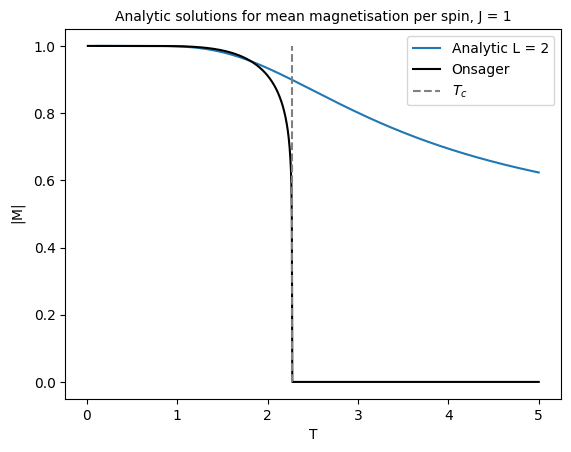

In [199]:
Ts_2x2 = np.linspace(0.1,5,1000)
Ms_2x2 = []

for T in Ts_2x2:
    Ms_2x2.append(0.25*(8*np.exp(8*T**-1)+16)/(4*np.cosh(8*T**-1)+12))

plt.plot(Ts_2x2, Ms_2x2, label = 'Analytic L = 2')
plt.plot(Ts_analytic, M_analytic, color = 'black', label = 'Onsager')
plt.plot(np.full((5,1),T_c), np.linspace(0,1,5), linestyle = '--', color = 'gray', label = r'$T_c$')
plt.xlabel('T')
plt.ylabel(r'$\vert$M$\vert$')
plt.title('Analytic solutions for mean magnetisation per spin, J = ' + str(J), fontsize = 10)
plt.legend()
plt.show()

*Fig. 3 - The Onsager solution and analytic mean magnetisation per spin solutions against temperature*

It is infeasible to repeat this process for lattices of any useful size due to the $2^{N \times N}$ possible states. For example $N = 5$ gives $33554432$ possible states, making $Z$ infeasibly hard to find. Due to this, an alternative approach to the simulation of larger lattices is needed. This is the aim of the Markov Chain Monte Carlo algorithms, otulined below.

### 2 - Markov Chain Monte Carlo

The two algorithms investigated are variations of a Markov Chain Monte Carlo (MCMC) method, that approach and evolve the desired physical state. Direct sampling Monte Carlo, while simpler, would require individually producing each state $X_i$. This is infeasibly slow. Instead, we use the MCMC methods, which produce a state $X_{i + 1}$ from an alteration of the $X_i$ state. One of the downsides of the MCMC methods is that this means consecutive states are not independent. This is quantified by the sample autocorrelation, discussed in more detail in section 4.

The MCMC starts with some initial state, $x_0$, and a state $x_{i+1}$ is produced from a state $x_i$ with a transition probability $p(x_{i + 1} \vert x_{i})$. Therefore the the chance of a particular sequence of states from $x_0$ to $x_n$ is:

$p_{path}(x_0 \rightarrow x_n) = p(x_0)\prod_{i = 0}^n p(x_{i + 1} \vert x_{i})$ (8)

*(This assumes that our markov chain is time homogenous, i.e. the chance of the transition $i \rightarrow j$ is irrelevant of the step in which the transition occurs)*

Suppose now we wish to simply find the chance of arriving at the state $x_n$ in $n$ steps, $p^{(n)}(x)$, regardless of path. Naively, this would involve summing over every singly possible path to every single possible final value to get the full distribution.

This can also be represented as taking a vector $\overrightarrow{p}^{(1)}$ whose $j^{th}$ element is $p^{(1)}(j)$ and acting on it $n-1$ times with a matrix $\textbf{P}$, with elements $\textbf{P}_{ij} = p(i \vert j)$:

$ \overrightarrow{p^{(n)}} = \textbf{P}^{n-1} \overrightarrow{p^{(1)}} $ (9)

For physical systems that reach equilibrium, we expect that, as $ n \rightarrow \infty$, our state vector will approach an unchanging distribution. This is called the *stationary distribution* and is commonly represented with $\pi$. As this stationary distribution does not change, trivially:

$ \pi\textbf{P} = \pi$ (10)

To implement MCMC algorithms, one must look for a method to find the transition matrix, $\textbf{P}$, from the intended stationary distribution. However, for complicated systems such as the Ising model studied here, $\pi$ cannot be analytically calculated and supplied. Therefore a different approach is required.

Firstly, note that our energy equation above is time-reversal symmetric as is the system, hence the probability of $i \rightarrow j$ is equal to the probability $j \rightarrow i$ for a step in the markov chain.

From this follows:

$ \pi_j\textbf{P}_{jk} = \pi_k = \textbf{P}_{jk}\pi_k $ (11)

using the eigenvector property of $\pi$ additionally. This constraint is known as *detailed balance*, and enables the use of simpler distributions to converge on the static distribution.

To approach this, each element of $\textbf{P}$ is split into a proposal probability distribution, $p_prop(j \vert k)$, that gives the chance of attempting to reach state $k$ from $j$, and an acceptance distribution, $p_{acc}(j \rightarrow k)$, that gives the chance of the change of state being accepted:

$ p( j \vert k) = p_{acc}(j \rightarrow k) p_{prop}(j \vert k) $ (12)

With the detailed balance condition, this results in the condition:

$\frac{p_{acc}(j \rightarrow k)}{p_{acc}(k \rightarrow j)} = \frac{\pi_k}{\pi_j} \frac{p_{prop}(j \vert k)}{p_{prop}(k \vert j)} $ (13)

A $p_{acc}$ is sought that satisfies this constraint.

### 3 - The Metropolis-Hastings algorithm

The Metropolis-Hasting (MH) algorithm follows the above logic, and the choice of $p_{acc}$ is:

$p_{acc}(j \rightarrow k) = min(1,\frac{\pi_k}{\pi_j} \frac{p_{prop}(j \vert k)}{p_{prop}(k \vert j)})$ (14)

The general MH algorithm proceeds as follows from a starting state $j$:

1. From an initial state $j$, pick a new state $k$ in line with the $p_{prop}$ distribution.
2. Accept the transition to $k$ with probability $p_{acc}(j \rightarrow k)$, and move to state $k$, or reject the move (with probability $ 1 - p_{acc}(j \rightarrow k )$) and remain in state $j$.
3. Return to 1.

This algorithm does not have a defined end point, so the end point is determined in this report by a predetermined number of iterations. This can be defined more rigorously later on, through utilisation of the autocorrelation time, $\tau_f$. Independent samples are generally considered to have occured every $\sim 2 \tau_f$, hence the number of total iterations can be varied, but should be several $\tau_f$.[8]

To apply this to the Ising model, states $j, k, etc.$ are taken to be unique arrangements of spins in the lattice. This means for a lattice containing $N$ spins, there are have $2^N$ possible states. New states $k$ are generated by choosing a random spin in $j$ and flipping it. The spin to flip is chosen from a uniform random distribution, hence $p_{prop}(k \vert j) = \frac{1}{N}$. The sought stationary distributions is equation (4), combining this with (11):

$p_{acc}(j \rightarrow k) = min(1, \frac{e^{-\beta E_k}}{e^{- \beta E_j}}) = min(1, e^{-\beta \Delta E})$ (15)

Notice that the partition function, $Z$, is not a dependent of $p_{acc}$, as it is cancelled in the ratio $\frac{\pi_k}{\pi_j}$.

From equation (1),

$\Delta E = 2 J \sigma_i \sum_j \sigma_j + 2 \mu H \sigma_i  $ (16) [2]

For the flip of a spin at a location $i$, with near neighbours $j$

This algorithm is easy to implement, but has a few shortcomings. Firstly, about the critical temperature, $T_c$, where the lattice undergoes a sharp change in behaviour, the MH algorithm displays an inherent issue of critical slowing down - the lattice has global behaviour which cannot be captured in flipping a single spin, and hence many iterations are required to reach a reliable stationary distribution.

MH also has some intrinisic properties. Firstly, it is a completely general MCMC technique that can be applied to most statistical physics problems, for example it is also applicable to the hard disk crystal model [2]. Additionally, MH can quite easily be parallelised to allow for faster computation. The implementation of MH used in this report is included in the GitHub repository as *MH_algorithm.py*

### 4 - The Wolff Cluster algorithm

The Wolff cluster algorithm is a separate algorithm used for the Ising model. It seeks to reach the stationary distribution quicker, and mitigate the issue of critical slowing down by forming clusters of like spins within the lattice and attempting to flip them all at once. This allows it to reach likely states that are significantly different from the current state in many fewer iterations by flipping a large number of spins together in each iteration. This algorithm as applied to the Ising model proceeds as follows:

1. A random site in the lattice $i$ with spin $\sigma_i$ is picked and added to the cluster.
2. Each neighbour of $i$ that also has spin $\sigma_i$, is added to the cluster with probability $1- e^{-2 \beta J}$.
3. Repeat step 2 for each neighbour added to the cluster until no more spins are added to the cluster.
4. Now that the cluster is defined flip each spin in the cluster and return to step 1. [3]

This is a rejection free algorithm, which means that in each iteration at least one spin is flipped and the state is changed. Therefore, this algorithm will display (usually small) fluctuations about equilibrium, whereas the MH algorithm will not necessarily.

The Wolff algorithm as outlined above is specific to the Ising model and cannot be applied to other problems that require an MCMC approach. This is a major disadvantage in comparison to the MH algorithm. It can be parrallelised like the MH algorithm [4]. The implementation of Wolff used in this report is included in the GitHub repository as *Wolff_algorithm.py*.

### 5 - Autocorrelation and quantification of critical slowing down

In order to investigate the feasability and scaling of these algorithms, an estimate of the number of iterations needed between independent samples of the lattice are needed. It is generally considered that an independent sample can be taken every $\sim 2\tau_f$ iterations, where $\tau_f$ is the autocorrelation time, and it can be estimated as follows:

To estimate the autocorrelation time, the *sample autocorrelation*, $\bar\rho(t)$ is required:

$\bar\rho(t) = \frac{\bar\gamma(t)}{\bar\gamma(0)}$ (17)

Where $\bar\gamma(t)$ is the *sample autocovariance*, defined below:

$\bar\gamma(t) = \frac{1}{n-t}\sum_{i=1}^{n-t}(f(X_i)-\bar f(X))(f(X_{i+t})-\bar f(X))$ (18)

This sample autocorrelation is a convenient measure of the degree of correlation of the observable $f$ on state $X_t$ at time $t$ with other states in the chain. To determine autocorrelation time, it is assumed that $\bar\rho(t)$ decays exponentially, with the characteristic decay scale of the autocorrelation time, $\tau_f$:

$\bar\rho(t) \approx e^{{t}/{\tau_f}}$ (19) [5]

Under this assumption, the autocorrelation time is estimated by the time of the first value of $\bar\rho(t)$ such that $\bar\rho(t) \le \frac{1}{e}$. It is also important to note that the autocorrelation time will be different for different variables.

If $n$ states have been generated in a simulation, there are roughly $n_f = \frac{n}{2\tau_f}$ independent samples generated for the observable $f(X)$. This shows that for a larger autocorrelation time, a smaller number of independent samples can be collected, and more iterations are needed. Therefore,the interations required to take a representative average of an observable becomes much larger. This is *slowing down* of the algorithm.

The Ising model has critical exponents, similar to many thermodynamic systems that display a phase transition. As $T \rightarrow T_c$, these can be used to describe the behaviour of observables using simple power laws.

$\xi \sim \vert T - T_c \vert ^{-\nu}$

$\tau_f \sim \vert T - T_c \vert ^{-\nu z}$ (20)[7]

where $\xi$ is the correlation length of the lattice, and $\nu$ is one of the critical exponents of the Ising model. In two dimensions, $\nu = 1$ [10]. Note that critical exponents are a universal property of the model and do not change between algorithms. $z$ is the *dynamic exponent* and does vary between algorithms. Clearly, near the critical temperature the autocorrelation time for our algorithms is expected to be very large, and collecting independent samples quickly becomes infeasible. This is *critical slowing down* and presents a significant challenge to the computational investigation of the system with these methods.

For an infinite lattice near $T_c$, $\xi$ will diverge towwards infinity, as the lattice displays fluctuations on all scales. However, for finite lattices this is not possible. Therefore, near $T_c$, $\xi \sim L$ where $L$ is the lattice width. Using this, in the critical regime:

$\tau_f \sim L ^{z}$

$ln(\tau_f) \sim zln(L)$ (21)

This describes the finite scaling of the algorithm. Any algorithm with a positive dynamic exponent will display the issue of critical slowing down. The magnitude of $z$ determines the severity in terms of iterations. A method with a smaller dynamic exponent will take many fewer iterations per independent sample, and hence will be a more feasible method for large lattices, even if the CPU time for a single iteration is much longer.

## Collecting independent measurements

Each state in the Markov Chain is generated from the previous state. Therefore, two states $X_i$ and $X_{i + 1}$ cannot be considered to be independent measurements of the system. To obtain statistically independent measurements, the states $X_i$ and $X_j$ must be significantly decorrelated. This is by convention considered to be satisifed when $j \ge i + 2 \tau_f$.

The error in these observables must also be treated with care. The expectation value of an observable $f(X)$ can be determined through the sample mean, and the error in this measurmeent through the error of the mean. For $n$ samples taken in the thermalised region, therefore:

$\mathbb{E}(f(X)) = \frac{1}{n} \sum_i^n f(X_i)$ (22)

A naive estimate of the error, assuming each data point is fully independent is given by:

$\sigma_{f(X)}^2 = \frac{1}{n - 1} (\langle f(X)^2 \rangle - \langle f(X) \rangle)$ (23)

To account for the fact that each data point is not independent, a different measure of the error is required:

$\sigma_{f(X)}^2 = \frac{1 + 2 \tau_f}{n - 1} (\langle f(X)^2 \rangle - \langle f(X) \rangle) \approx \frac{1}{n_f - 1}  (\langle f(X)^2 \rangle - \langle f(X) \rangle)$ (24)

With $n_f$ as defined above and assuming that $\tau_f \gg 1$ [8].

To utilise a simulated series of $n$ meassurements of an observable after thermalisation and produce a utilisable mean and error, a blocking method is used. A series of $n$ data points is divided into bins of approximately $ 1 / 2 \tau_f $ elements. As each data set starts at state $X_{ m \times 2 \tau_f }$ for integral $m$, each set may be treated as an entire sample, with mean and error given by equations (21) and (23). This is further useful for the calculation of derived variables such as **VAR**, as these necessarily require a series of measurements to calculate. Each batch can be treated as a series, and an expectation and error can be found using the mean and the naive mean error. 
 


## Investigation

### 1 - Qualitative investigation of the lattice evolution

As a first test of the MH and Wolff algorithms, A $25 \times 25$ lattice is evolved and displayed to determine visually if the algorithms perform as expected.

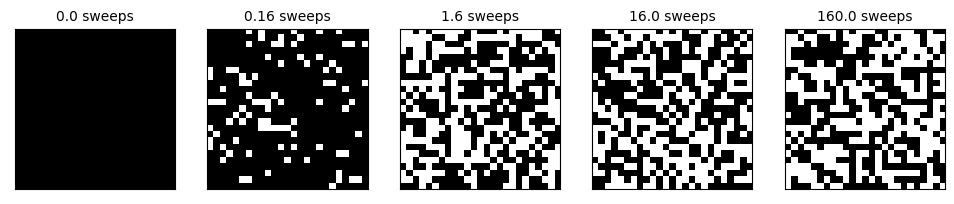

Time to execute = 2.241 seconds.


In [16]:
# Initialise lattice
lattice = lat.make_lattice(25,1)
plot_times = [0,100,1000,10000,100000]
# Time run length:
start_time = time.time()
# Evolve
MH.evolve_and_show(lattice, 2, 0,0, plot_times)
end_time = time.time()
print('Time to execute = ' + str(np.round(end_time-start_time,3)) + ' seconds.')
plt.show()

*Fig. 4 - Evolution of a $25 \times 25$ lattice with the Metropolis-Hastings algorithm, $J = 0$, $T = 0.5$*

Time to execute = 11.307104110717773 seconds.


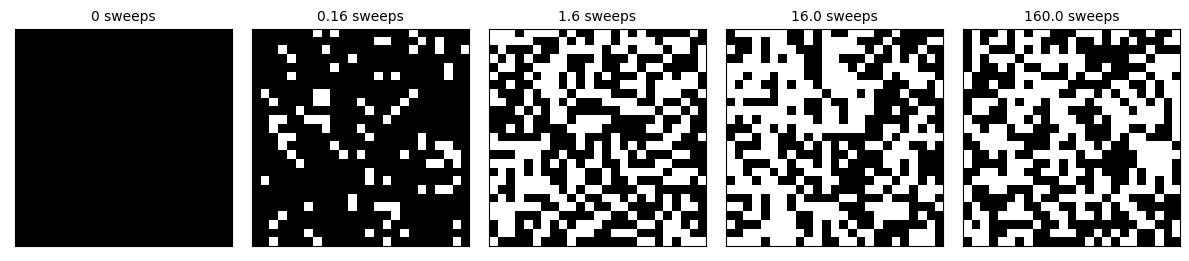

In [18]:
# Re-initialise lattice
lattice = lat.make_lattice(25,1)
# Time run length:
start_time = time.time()
# Evolve
W.Wolff_evolve_and_show(lattice, 2, 0, plot_times)
end_time = time.time()
print('Time to execute = ' + str(end_time - start_time) + ' seconds.')
plt.tight_layout()
plt.show()

*Fig. 5- Evolution of a $25 \times 25$ lattice with the Wolff algorithm, $J = 0$, $T = 0.5$*

Both algorithms lead to the progression of the lattice from its initial state to a random spin assortment. This is to be expected at non-zero temperatures in the presence of no coupling, as with $J = H = 0$, the Ising energy is 0, so any state is equally likely.

### 2 - Thermalisation

Before any measurements of observables can be taken, the system must be allowed to reach equilibrium, where the transient behaviour from the intiial condition to equilibrium has diminished, and the observable is thermally fluctuating about a fixed value. The absolute magnetism per spin versus sweeps is plotted below for a $25 \times 25$ lattice, from a hot start. The Wolff algorithm takes 

In [51]:
lattice = lat.make_lattice(25,0)
MH_Ms, MH_sweeps = MH.evolve_and_compute_M(lattice, 1**-1, 1, 0, 100000)
MH_thermal_Ms, MH_thermal_sweeps = MH.evolve_and_compute_M(lattice, 1**-1, 1, 0, 50000)
lattice = lat.make_lattice(25,0)
Wolff_Ms, Wolff_sweeps = W.Wolff_evolve_and_compute_M(lattice, 1**-1, 1, 100)
Wolff_thermal_Ms, Wolff_thermal_sweeps = W.Wolff_evolve_and_compute_M(lattice, 1**-1, 1, 50)
fig, ax  = plt.subplots(1,2, figsize = (15,7.5))

ax[0].plot(MH_sweeps, MH_Ms, label = 'MH, 10,000 moves')
ax[0].plot(Wolff_sweeps, Wolff_Ms, label = 'Wolff, 1000 moves')
ax[0].set_xlim(right = min(MH_sweeps[-1],Wolff_sweeps[-1]))
ax[0].legend()
ax[1].plot(MH_thermal_sweeps, MH_thermal_Ms, label = 'MH, 100,000 moves')
ax[1].plot(Wolff_thermal_sweeps, Wolff_thermal_Ms, label = 'Wolff, 1000 moves')
ax[1].set_xlabel('Sweeps')
ax[0].set_xlabel('Sweeps')
ax[1].set_xlim(right = min(MH_thermal_sweeps[-1],Wolff_thermal_sweeps[-1]))
ax[1].set_ylabel(r'$\vert$M$\vert$')
ax[0].set_ylabel(r'$\vert$M$\vert$')
ax[0].set_title('Entire evolution')
ax[1].set_title('Thermalised region')
fig.suptitle(r'$\vert$M$\vert$ against sweeps for Metropolis-Hastings and Wolff')
plt.show()